In [1]:
import numpy as np
import json, sys, os

import matplotlib.pyplot as plt
from matplotlib import rc, cm

## Preparing astropy units and constants to be used later
from astropy import units as u
from astropy import constants as const

# Get the path of the current directory
path = os.getcwd()
home = os.path.dirname(path)

# Print the repository home directory
print("Repository home directory:",home)

# Add the src folder to the system path
sys.path.append(home+'/src')

# Import the python functions stored in the src folder
from calculations import Calc, Model, Stats

# We shorten the functions name to make it easier to call the required a functions
## 3 functions from P.Strom written code
c   = Calc()
m   = Model()
s   = Stats()

## My set_w function 
### Revisitied in week 5 to set it as a new variable rather than overwriting w (could have caused problems with repetition)

def set_w(lowerw,upperw):
    # Must make w, w_LHS and w_RHS global here so that they can be recalled later outside of the function
    #otherwise they stay as just local inside set_w
    global w
    global w_trim
    global w_LHS
    global w_RHS
    
    #Finding the wavelength range to then find the number of data points per angstrom
    w = D[0][0][0][0:20248]
 
    # Wavelength range
    w_range = (w[20247]-w[0])

    # Data points per wavelength
    p_per_w = 20248/w_range
    
    LHS_gap_w = (lowerw-w[0]) #LHS difference in angstroms 
    LHS_gap_d = LHS_gap_w*p_per_w # LHS difference in points
    LHS_gap_d = round(LHS_gap_d)
    
    RHS_gap_w = (w[20247]-upperw) #RHS difference in angstroms 
    RHS_gap_d = RHS_gap_w*p_per_w # RHS difference in points
    RHS_gap_d = round(RHS_gap_d)
    
    w_LHS = 0 + LHS_gap_d
    w_RHS = 20248 - RHS_gap_d

    w_trim = D[0][0][0][w_LHS:w_RHS] #Redefining w with its new boundaries
    
    print("w_trim = ")
    return(w_trim)



# Importing parameters from a json file.
# You can use this file to edit parameters later.

## Editing the paramenters in a file proves easier than writing it into the code 
with open(home+'/params.json') as param_file:    
   param = json.load(param_file)

# We read in the data directories we are using. To see what directories this is open params.json.
datadirs = param["datadirs"]

# Choose what part of the spectrum you wan to look at
# B is the blue end, whilst A is the red end)
part     = param["BetaPictoris"]["part"]


## Just added this into the first cell as there wasnt any reason to have them split every other week
# Load the data into the multidimentional array D
if param["filenames"]["split_files"] == "yes":
    D = c.LoadData(home+'/data/D_'+part+'_split.npz')
else:
    D = c.LoadData(home+'/data/D_'+part+'.npz')

Repository home directory: C:\Users\Oliver\Documents\urss


In [2]:
# Testing the function (added "w_trim = " to remind to use its new name)
set_w(1320,1440)

w_trim = 


array([1319.69879417, 1319.70876084, 1319.71872751, ..., 1438.79052125,
       1438.80048792, 1438.81045459])

In [3]:
## From Week 2 and 3
## Code for Normalising the Points in new reigon

# Creating empty lists for our Flux, Error in Flux, corrected flux values 
d0 = [] # Flux
e0 = [] # Error
d0_n = [] # Corrected flux values (Normalised)

# Extracting the Flux and Flux Error data for each observation and putting them into d0 and e0
for i in range(len(D)): # For each visit (repeat for all 13 data collections)
    for j in range(len(D[i])): # Within each visit (cycle over number of orbits)
        if j == 0: # If orbit == 0 (for the first orbit only - as we are interested in unshifted data)
            d0.append(D[i][j][1][w_LHS:w_RHS]) # Add to d0 the y values (Flux)
            e0.append(D[i][j][2][w_LHS:w_RHS]) # Add to e0 the y error values (Error in Flux)
                ## This is why I had to make w_LHS and w_RHS global earlier as well as w
            
# Converting lists into numpy arrays (allowing for easier manipulation later on with averaging functions)
d0 = np.array(d0)
e0 = np.array(e0)


# Normalisation - correcting for different exposure times (exposure time effects Flux, we move all into same frame)

for i in range(len(d0)): # For loop - repeating for each data set 
    factor = np.median(d0[i])/np.median(d0[0]) # Calculating the normalisation factor (how much each spectrum is off from 1st)
    d0_n.append(d0[i]/factor) # (Spectrum flux values/spectrum normalisation factor), making d0_n corrected flux values 


# Converting list into array - only after using .append 
d0_n = np.array(d0_n)

## Simple average
#d0_ave = np.average(d0,axis=0)

## Weighted average
#d0_w_ave = np.average(d0 , axis = 0 , weights = 1/e0**2)

## Normalised weighted average 
d0_n_w_ave = np.average(d0_n , axis = 0 , weights = 1/e0**2)


##Doppler Shift 

beta_pic_speed = 20.5*(u.km/u.s)
w_shifted = w_trim-(beta_pic_speed / const.c)*w_trim


In [4]:
import pandas as pd
df = pd.read_csv(home+'/AtomicData_trim.csv',header=None)
print(df)

              0          1   2             3            4    5
0     1000.1150        ClI  35  7.730000e-07       3430.0  NaN
1     1000.1700      ArVI*  40  1.000000e-09  100000000.0  NaN
2     1000.2786        ClI  35  8.870000e-04   11800000.0  NaN
3     1000.4860   HDLP4V10   3  9.930000e-03  877000000.0  NaN
4     1000.6800   HDLP8V12   3  8.750000e-03  720000000.0  NaN
...         ...        ...  ..           ...          ...  ...
2350  1436.9670      S I**  32  2.230000e-01  240000000.0  NaN
2351  1441.8230       CoII  59  8.550000e-07       3530.0  NaN
2352  1444.2960        S I  32  8.130000e-04    2600000.0  NaN
2353  1448.0110       CoII  59  4.520000e-02  185000000.0  NaN
2354  1449.9969       NiII  59  3.530000e-03   16800000.0  NaN

[2355 rows x 6 columns]


Text(0, 0.5, 'Flux [erg/s/cm$^2$/\\AA]')

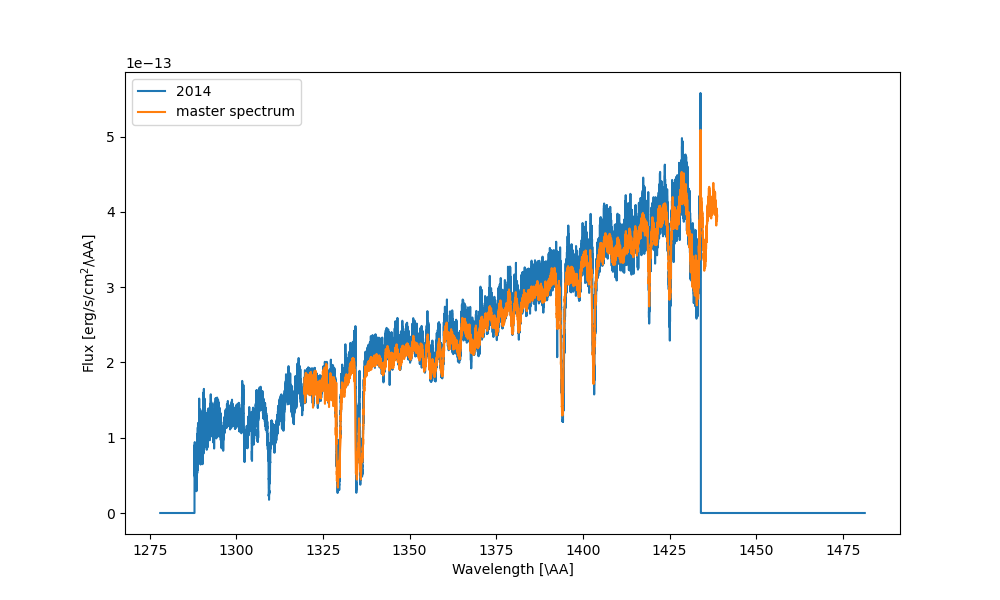

In [15]:
fig = plt.figure(figsize=(10.0,6.0))
w=D[0][0][0]
plt.step(w,D[0][0][1],label="2014")
plt.plot(w_shifted,d0_n_w_ave,label="master spectrum")
plt.legend(loc='upper left', numpoints=1)
plt.xlabel(r'Wavelength [\AA]')
plt.ylabel(r'Flux [erg/s/cm$^2$/\AA]')

(1314.0, 1442.0)

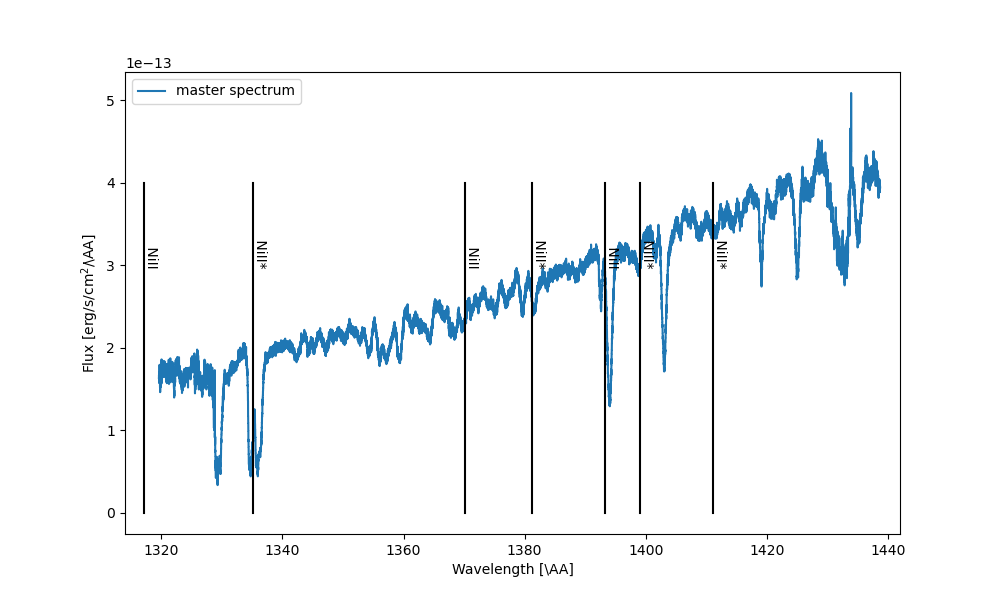

In [5]:
%matplotlib widget
fig = plt.figure(figsize=(10.0,6.0))
plt.step(w_shifted,d0_n_w_ave,label="master spectrum")

for index, row in df.iterrows():
    if part == 'A':
        if 1315 < row[0] < 1440 and row[3] > 0.01 and 'Ni' in row[1]:
            plt.text(row[0],3e-13,row[1],rotation=-90)
            plt.plot([row[0],row[0]],[0,4e-13],color="black")
              
    else:
        if 1162 < row[0] < 1286 and row[3] > 0.005:
            plt.plot([row[0],row[0]],[0,5e-13],color="black")
            plt.text(row[0],1e-14,row[1],rotation=-90)  

plt.legend(loc='upper left', numpoints=1)
plt.xlabel(r'Wavelength [\AA]')
plt.ylabel(r'Flux [erg/s/cm$^2$/\AA]')
plt.xlim(1314,1442)
#plt.xlim(1162,1286)
#plt.ylim(0,0.18e-12)

Text(0, 0.5, 'Flux [erg/s/cm$^2$/\\AA]')

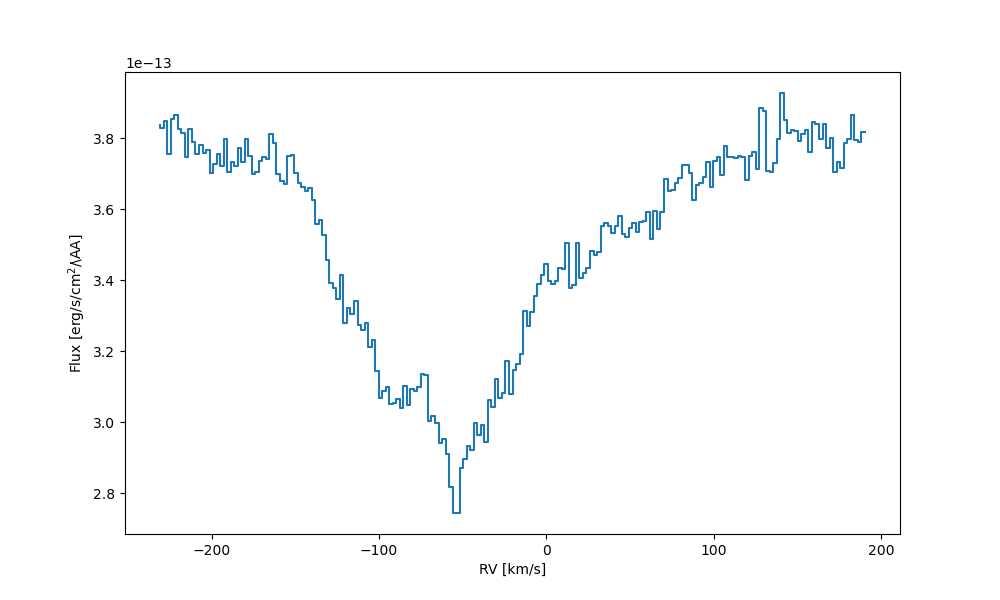

In [20]:
chosen_line = 'CoII'
line = param["lines"]["line"][chosen_line]["Wavelength"]
s1, s2 = c.RegionSelect(w_shifted, line-1, line+1)

W = w_shifted[s1:s2]
S = d0_n_w_ave[s1:s2]

# This function converts from wavelength to RV values and puts it in the $\beta$ Pic reference frame.
RV = c.Wave2RV(W,param["lines"]["line"][chosen_line]["Wavelength"],param["BetaPictoris"]["RV"])

fig = plt.figure(figsize=(10.0,6.0))
plt.step(RV,S)
plt.xlabel(r'RV [km/s]')
plt.ylabel(r'Flux [erg/s/cm$^2$/\AA]')

In [21]:
def absorption(l, v_comp, N, vturb, T, species):
    # v_comp --> The component speed in km/s
    # N --> The column density exponent (10**N)
    # vturb --> Micro turbulence
    # T --> Gas temperature
    # species --> Given in params.json

    w       = param["lines"]["line"][species]["Wavelength"]
    mass    = param["lines"]["line"][species]["Mass"]
    fosc    = param["lines"]["line"][species]["Strength"]
    delta   = param["lines"]["line"][species]["Gamma"] /(4.*np.pi)
    N_col   = np.array([1.])*10**N

    c_light     = 2.99793e14        # Speed of light
    k           = 1.38064852e-23    # Boltzmann constant in J/K = m^2*kg/(s^2*K) in SI base units
    u           = 1.660539040e-27   # Atomic mass unit (Dalton) in kg
    feature  = np.ones(len(l))

    b_wid   = np.sqrt((T/mass) + ((vturb/0.12895223)**2))
    b       = 4.30136955e-3*b_wid
    dnud    = b*c_light/w
    xc      = l/(1.+v_comp*1.e9/c_light) 
    v       = 1.e4*abs(((c_light/xc)-(c_light/w))/dnud)
    tv      = 1.16117705e-14*N_col*w*fosc/b_wid
    a       = delta/dnud
    hav     = tv*m.voigt_wofz(a,v)

    # To avoid calculating super tiny numbers
    for j in range(len(hav)):

        if hav[j] < 50:      
            feature[j]  =   feature[j]*np.exp(-hav[j])       
        else:
            feature[j]  =   0.



In [49]:
p1, p2 = c.RegionSelect(W, 1343.5, 1344.15)
p3, p4 = c.RegionSelect(W, 1344.7, 1345.2)
x_fit_region = np.concatenate((W[p1:p2],W[p3:p4]))
y_fit_region = np.concatenate((S[p1:p2],S[p3:p4]))
polynomial_coeff= np.polyfit(x_fit_region,y_fit_region,3)
continuum=np.polyval(polynomial_coeff,W)

UnboundLocalError: local variable 'start' referenced before assignment